# Title: Block VQE with Runtime

In this file we will generate the blocks from the Hamiltoniain and run a previously saved runtime program.  

# Generating the blocks

For now I will generate the blocks from a matrix representation of the Hamiltonian.  This can be optimized later on using binary numbers and masks.  

We will explore this Hamiltonian:
$$ 
    H =  \sum_{i} \left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1} + z Z_{i} Z_{i+1}\right) 
$$
breaking it up into two piecies, one which will be solved classically and the other which will be solved via VQE.

\begin{equation}
\begin{split}
H_{c,c'}=& T_{c,c'} + \delta_{cc'}\sum_{i=0}^{N_q} \left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1}  + z Z_{i} Z_{i+1}\right) 
\\
&+ \left(B^{1x}_{c,c'}X_{0} + B^{1y}_{c,c'} Y_{0} + B^{1z}_{c,c'} Z_{0} \right)
\end{split}
\end{equation}
Notice that I have shifted the chaing so that the quantum part now starts at $i=0$.  The classical part contains the following paramters
\begin{equation}
\begin{split}
& T_{c,c'} =  <c'|\sum_{i=0}^{N_c-2}\left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1} + z Z_{i} Z_{i+1}\right)|c> 
\\
& B1^x_{c,c'} =  x<c'|X_{N_c-1}|c>
\\
&B1^y_{c,c'} = y<c'|Y_{N_c-1}|c> 
\\
&B1^z_{c,c'} = z<c'|Y_{N_c-1}|c> 
\end{split}
\end{equation}

In [28]:
import qiskit.quantum_info as qi

def X(i,N):
    label = ['I' for i in range(N)]
    label[i] = 'X'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def Y(i,N):
    label = ['I' for i in range(N)]
    label[i] = 'Y'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def Z(i,N):
    label = ['I' for i in range(N)]
    label[i] = 'Z'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

In [29]:
# A function to print the state given the numerical represenations
def bi(num,N):
    bi = bin(num)
    out = []
    Sdiff = N - len(bi) + 2
    for i in range(0,Sdiff):
        out.append(0)
    for i in range(2,len(bi)):
        out.append(int(bi[i]))
    return out

# A function which retruns the numerical representation of states given N
def states(N):
    out = [i for i in range(0,2**N)]
    return out

# A function to print the basis vectors given the number of qubits N
def vecs(N):
    out = []
    for i in range(2**N):
        v = [0 for i in range(2**N)]
        v[i] = 1
        out.append(v)
    return out

In [30]:
import numpy as np

def Mdot(Ol):
    out = Ol[0]
    for i in range(1,len(Ol)):
        out = np.dot(Ol[i],out)
    return out

def bkt(y1,O,y2):
    return Mdot([np.conjugate(y1),O,y2])

In [31]:
def H(x,y,z,N):
    h = 0*X(0,N)
    for i in range(0,N-1):
        h += x*Mdot([X(i,N),X(i+1,N)]) + y*Mdot([Y(i,N),Y(i+1,N)]) + z*Mdot([Z(i,N),Z(i+1,N)])
    return h
        
    
import pandas as pd

In [32]:
def T(x,y,z,c,cc,Nc):
    out = 0
    v = vecs(Nc)
    for i in range(0,Nc-1):
        O = x*Mdot([X(i,Nc),X(i+1,Nc)]) + y*Mdot([Y(i,Nc),Y(i+1,Nc)]) + z*Mdot([Z(i,Nc),Z(i+1,Nc)])
        out += bkt(v[cc],O,v[c])
    return out

def Bx(x,c,cc,Nc):
    out = 0
    v = vecs(Nc)
    O = X(Nc-1,Nc)
    out += bkt(v[cc],x*O,v[c])
    return out

def By(y,c,cc,Nc):
    out = 0
    v = vecs(Nc)
    O = Y(Nc-1,Nc)
    out += bkt(v[cc],y*O,v[c])
    return out

def Bz(z,c,cc,Nc):
    out = 0
    v = vecs(Nc)
    O = Z(Nc-1,Nc)
    out += bkt(v[cc],z*O,v[c])
    return out

In [33]:
from qiskit.opflow.primitive_ops import MatrixOp
from qiskit import quantum_info as qi

def H_quantum(x,y,z,c,cc,Nc,Nq):
    tcc = T(x,y,z,c,cc,Nc)
    Iq = np.identity(2**Nq)
    h = [MatrixOp(tcc*Iq).to_pauli_op()]
    h.append(MatrixOp(Bx(x,c,cc,Nc)*X(0,Nq)).to_pauli_op())
    h.append(MatrixOp(By(y,c,cc,Nc)*Y(0,Nq)).to_pauli_op())
    h.append(MatrixOp(Bz(z,c,cc,Nc)*Z(0,Nq)).to_pauli_op())
    if c == cc:
        for i in range(0,Nq-1):
            h.append(MatrixOp(x*Mdot([X(i,Nq),X(i+1,Nq)])).to_pauli_op())
            h.append(MatrixOp(y*Mdot([Y(i,Nq),Y(i+1,Nq)])).to_pauli_op())
            h.append(MatrixOp(z*Mdot([Z(i,Nq),Z(i+1,Nq)])).to_pauli_op())
    return h

In [34]:
from qiskit.opflow import SummedOp, PauliOp

def Blocks(x,y,z,Nc,Nq):
    bks = {}
    Mc = len(states(Nc))
    for c in range(0,Mc):
        for cc in range(0,Mc):
            Op = H_quantum(x,y,z,c,cc,Nc,Nq)
            bks[str(c) + ',' + str(cc)] =  Op
    return bks

In [35]:
#Blocks(1,2,3,2,3)

Compare the blocks to the original Hamiltonian

In [36]:
Nc = 2
Nq = 3
x = 1
y = 2
z = 3
blocks = Blocks(x,y,z,Nc,Nq)

keys = list(blocks.keys())

bL = len(states(Nc))
size = 2**Nq
H_complete = np.array([[0 for i in range(size*bL)] for j in range(size*bL)])

for bi in range(bL):
    for bj in range(bi,bL):
        key = str(bi) + ',' + str(bj)
        if key  in keys:
            hl = blocks[key]
            block = np.sum(hl).to_matrix()
        else:
            block = np.array([[0.0 for i in range(size)] for j in range(size)])
        for i in range(size):
            for j in range(size):
                H_complete[i + bi*size, j + bj*size] = block[i,j]
                H_complete[i + bj*size, j + bi*size] = block[j,i]

<ipython-input-36-f43942b05d04>:24: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bi*size, j + bj*size] = block[i,j]
<ipython-input-36-f43942b05d04>:25: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bj*size, j + bi*size] = block[j,i]


In [37]:
np.amax(np.abs(H_complete - np.real(H(x,y,z,Nc+Nq))))

0.0

# Running the program

## Build the initial anzats angles

In [38]:
bL = 2**Nc
alpha = 1/np.sqrt(bL)*np.array([1 for b in range(bL)])
#number of blocks
T = 2
phi = []
for b in range(bL):
    phi_b = []
    for ti in range(T):
        phi_t = []
        for q in range(Nq):
            phi_t.append(0)
        phi_b.append(phi_t)
    phi.append(phi_b)

## Importing the runtime program

In [119]:
import os
from qiskit import IBMQ

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-afrl', group='air-force-lab', project='quantum-sim')  # Substitute with your provider.


ibmqfactory.load_account:WARNING:2021-11-02 10:39:54,389: Credentials are already in use. The existing account in the session will be replaced.


In [190]:
program_id = 'block-vqe'
my_program = provider.runtime.program(program_id)

#print(my_program)

## Run the program

### Simulation

In [191]:
def interim_result_callback(job_id, interim_result):
    print(f"interim result: {interim_result}")

In [195]:
backend = provider.backend.ibmq_qasm_simulator
options = {'backend_name': backend.name()}
inputs = {"k_max": 2000, "phi": phi, "alpha": alpha, "blocks":blocks, "seeded":True, "method":"simple"}
job = provider.runtime.run(program_id, options=options, inputs=inputs, callback=interim_result_callback)

In [196]:
print(f"job id: {job.job_id()}")
result = job.result()
#print(result)

job id: c60ls7t0p3h5hl49umk0
interim result: {'Starting program with k_max': 2000}
interim result: {'seeding is on': True}
interim result: {'starting iteration': 0}
interim result: {'k': 0, 'E_A': (6.394769974311853+0j)}
interim result: {'k': 0, 'E_B': (2.830183628909674+0j)}
interim result: {'k': 0, 'E_f': 5.258741406612572}
interim result: {'starting iteration': 1}
interim result: {'k': 1, 'E_A': (3.4707413889781233+0j)}
interim result: {'k': 1, 'E_B': (8.068810435861572+0j)}
interim result: {'k': 1, 'E_f': 4.477584957491599}
interim result: {'starting iteration': 2}
interim result: {'k': 2, 'E_A': (2.9701641465724364+0j)}
interim result: {'k': 2, 'E_B': (5.713708436891429+0j)}
interim result: {'k': 2, 'E_f': 4.180102714107959}
interim result: {'starting iteration': 3}
interim result: {'k': 3, 'E_A': (3.496420674330254+0j)}
interim result: {'k': 3, 'E_B': (1.9265897725870582+0j)}
interim result: {'k': 3, 'E_f': 3.8590587539580445}
interim result: {'starting iteration': 4}
interim res

interim result: {'k': 38, 'E_B': (-9.076959790152555+0j)}
interim result: {'k': 38, 'E_f': -9.240387119483533}
interim result: {'starting iteration': 39}
interim result: {'k': 39, 'E_A': (-5.7887316457552425+0j)}
interim result: {'k': 39, 'E_B': (-7.217413078727966+0j)}
interim result: {'k': 39, 'E_f': -9.689168155032512}
interim result: {'starting iteration': 40}
interim result: {'k': 40, 'E_A': (-4.060374144811577+0j)}
interim result: {'k': 40, 'E_B': (-10.216829765779215+0j)}
interim result: {'k': 40, 'E_f': -10.65116763013507}
interim result: {'starting iteration': 41}
interim result: {'k': 41, 'E_A': (-7.202187666524278+0j)}
interim result: {'k': 41, 'E_B': (-8.755434035024548+0j)}
interim result: {'k': 41, 'E_f': -10.708795712745827}
interim result: {'starting iteration': 42}
interim result: {'k': 42, 'E_A': (-6.454882351973064+0j)}
interim result: {'k': 42, 'E_B': (-7.8988006824288+0j)}
interim result: {'k': 42, 'E_f': -10.541750328461967}
interim result: {'starting iteration': 

interim result: {'k': 77, 'E_A': (-8.278422375557343+0j)}
interim result: {'k': 77, 'E_B': (-6.85338250648559+0j)}
interim result: {'k': 77, 'E_f': -10.398004755442308}
interim result: {'starting iteration': 78}
interim result: {'k': 78, 'E_A': (-5.637037628205738+0j)}
interim result: {'k': 78, 'E_B': (-8.571745436001741+0j)}
interim result: {'k': 78, 'E_f': -10.146193352299157}
interim result: {'starting iteration': 79}
interim result: {'k': 79, 'E_A': (-9.040983197601284+0j)}
interim result: {'k': 79, 'E_B': (-5.879488319057121+0j)}
interim result: {'k': 79, 'E_f': -10.073253237703787}
interim result: {'starting iteration': 80}
interim result: {'k': 80, 'E_A': (-7.0432526846292856+0j)}
interim result: {'k': 80, 'E_B': (-8.028469127896336+0j)}
interim result: {'k': 80, 'E_f': -9.950607360114628}
interim result: {'starting iteration': 81}
interim result: {'k': 81, 'E_A': (-7.561179449857862+0j)}
interim result: {'k': 81, 'E_B': (-9.072675047991014+0j)}
interim result: {'k': 81, 'E_f': 

interim result: {'k': 115, 'E_f': -11.199604463994067}
interim result: {'starting iteration': 116}
interim result: {'k': 116, 'E_A': (-9.107294316409119+0j)}
interim result: {'k': 116, 'E_B': (-8.871011827687019+0j)}
interim result: {'k': 116, 'E_f': -11.234838940430956}
interim result: {'starting iteration': 117}
interim result: {'k': 117, 'E_A': (-8.651329385433453+0j)}
interim result: {'k': 117, 'E_B': (-5.495297427065793+0j)}
interim result: {'k': 117, 'E_f': -10.666003618944275}
interim result: {'starting iteration': 118}
interim result: {'k': 118, 'E_A': (-8.64445179177624+0j)}
interim result: {'k': 118, 'E_B': (-9.015624353130688+0j)}
interim result: {'k': 118, 'E_f': -10.712260311979508}
interim result: {'starting iteration': 119}
interim result: {'k': 119, 'E_A': (-8.748388949191419+0j)}
interim result: {'k': 119, 'E_B': (-6.9009667759658715+0j)}
interim result: {'k': 119, 'E_f': -10.503944480373521}
interim result: {'starting iteration': 120}
interim result: {'k': 120, 'E_A':

interim result: {'k': 153, 'E_f': -11.185820067359836}
interim result: {'starting iteration': 154}
interim result: {'k': 154, 'E_A': (-8.571490211812279+0j)}
interim result: {'k': 154, 'E_B': (-9.74231036074647+0j)}
interim result: {'k': 154, 'E_f': -11.154368103708354}
interim result: {'starting iteration': 155}
interim result: {'k': 155, 'E_A': (-8.959038400668302+0j)}
interim result: {'k': 155, 'E_B': (-11.512239250469712+0j)}
interim result: {'k': 155, 'E_f': -11.55680429256632}
interim result: {'starting iteration': 156}
interim result: {'k': 156, 'E_A': (-8.34058945773728+0j)}
interim result: {'k': 156, 'E_B': (-10.777467433454369+0j)}
interim result: {'k': 156, 'E_f': -11.546292101644942}
interim result: {'starting iteration': 157}
interim result: {'k': 157, 'E_A': (-9.967849703291211+0j)}
interim result: {'k': 157, 'E_B': (-9.7567714554365+0j)}
interim result: {'k': 157, 'E_f': -11.532617948569712}
interim result: {'starting iteration': 158}
interim result: {'k': 158, 'E_A': (-

interim result: {'k': 191, 'E_B': (-11.13082980647788+0j)}
interim result: {'k': 191, 'E_f': -12.038895047654272}
interim result: {'starting iteration': 192}
interim result: {'k': 192, 'E_A': (-9.61923701943624+0j)}
interim result: {'k': 192, 'E_B': (-10.173906487125521+0j)}
interim result: {'k': 192, 'E_f': -11.964334540567792}
interim result: {'starting iteration': 193}
interim result: {'k': 193, 'E_A': (-10.529117576654588+0j)}
interim result: {'k': 193, 'E_B': (-7.460183573791243+0j)}
interim result: {'k': 193, 'E_f': -11.761496213922689}
interim result: {'starting iteration': 194}
interim result: {'k': 194, 'E_A': (-9.570814866115793+0j)}
interim result: {'k': 194, 'E_B': (-10.136811322568496+0j)}
interim result: {'k': 194, 'E_f': -11.829657276367316}
interim result: {'starting iteration': 195}
interim result: {'k': 195, 'E_A': (-8.967884909177556+0j)}
interim result: {'k': 195, 'E_B': (-10.925369179636329+0j)}
interim result: {'k': 195, 'E_f': -11.819177447181122}
interim result:

interim result: {'k': 229, 'E_A': (-10.149590825522472+0j)}
interim result: {'k': 229, 'E_B': (-10.831983048125814+0j)}
interim result: {'k': 229, 'E_f': -11.965227432736807}
interim result: {'starting iteration': 230}
interim result: {'k': 230, 'E_A': (-11.031102964559967+0j)}
interim result: {'k': 230, 'E_B': (-9.251626263845127+0j)}
interim result: {'k': 230, 'E_f': -11.92900014348502}
interim result: {'starting iteration': 231}
interim result: {'k': 231, 'E_A': (-10.978403973452972+0j)}
interim result: {'k': 231, 'E_B': (-9.282956883819013+0j)}
interim result: {'k': 231, 'E_f': -11.953068309653768}
interim result: {'starting iteration': 232}
interim result: {'k': 232, 'E_A': (-9.987669311180317+0j)}
interim result: {'k': 232, 'E_B': (-9.045153593119847+0j)}
interim result: {'k': 232, 'E_f': -11.87042928494866}
interim result: {'starting iteration': 233}
interim result: {'k': 233, 'E_A': (-10.427056069933949+0j)}
interim result: {'k': 233, 'E_B': (-9.238910993056278+0j)}
interim res

interim result: {'k': 267, 'E_A': (-10.803274455877485+0j)}
interim result: {'k': 267, 'E_B': (-9.942987873809006+0j)}
interim result: {'k': 267, 'E_f': -12.268102536454638}
interim result: {'starting iteration': 268}
interim result: {'k': 268, 'E_A': (-10.875616470003703+0j)}
interim result: {'k': 268, 'E_B': (-10.290555691069999+0j)}
interim result: {'k': 268, 'E_f': -12.239855964824702}
interim result: {'starting iteration': 269}
interim result: {'k': 269, 'E_A': (-10.835553486740814+0j)}
interim result: {'k': 269, 'E_B': (-11.271713116753824+0j)}
interim result: {'k': 269, 'E_f': -12.29538442987755}
interim result: {'starting iteration': 270}
interim result: {'k': 270, 'E_A': (-11.679625170180833+0j)}
interim result: {'k': 270, 'E_B': (-9.872463820450012+0j)}
interim result: {'k': 270, 'E_f': -12.326726079006695}
interim result: {'starting iteration': 271}
interim result: {'k': 271, 'E_A': (-11.568631912871403+0j)}
interim result: {'k': 271, 'E_B': (-9.710058999289352+0j)}
interim 

interim result: {'k': 305, 'E_A': (-10.48811575441441+0j)}
interim result: {'k': 305, 'E_B': (-11.619525054560826+0j)}
interim result: {'k': 305, 'E_f': -12.540852079863496}
interim result: {'starting iteration': 306}
interim result: {'k': 306, 'E_A': (-10.086068211361948+0j)}
interim result: {'k': 306, 'E_B': (-9.86593516371537+0j)}
interim result: {'k': 306, 'E_f': -12.555039949465348}
interim result: {'starting iteration': 307}
interim result: {'k': 307, 'E_A': (-11.167347180147582+0j)}
interim result: {'k': 307, 'E_B': (-9.715350422065388+0j)}
interim result: {'k': 307, 'E_f': -12.501003532091405}
interim result: {'starting iteration': 308}
interim result: {'k': 308, 'E_A': (-9.863757400280516+0j)}
interim result: {'k': 308, 'E_B': (-12.339285996965074+0j)}
interim result: {'k': 308, 'E_f': -12.926877792583158}
interim result: {'starting iteration': 309}
interim result: {'k': 309, 'E_A': (-9.270896552396092+0j)}
interim result: {'k': 309, 'E_B': (-11.189212635906312+0j)}
interim re

interim result: {'k': 343, 'E_A': (-10.638386945793092+0j)}
interim result: {'k': 343, 'E_B': (-12.984317627991919+0j)}
interim result: {'k': 343, 'E_f': -14.26703367655254}
interim result: {'starting iteration': 344}
interim result: {'k': 344, 'E_A': (-13.23256320029233+0j)}
interim result: {'k': 344, 'E_B': (-10.555668846148592+0j)}
interim result: {'k': 344, 'E_f': -14.103962984190645}
interim result: {'starting iteration': 345}
interim result: {'k': 345, 'E_A': (-9.9041274503697+0j)}
interim result: {'k': 345, 'E_B': (-11.927646675779211+0j)}
interim result: {'k': 345, 'E_f': -13.87070764692662}
interim result: {'starting iteration': 346}
interim result: {'k': 346, 'E_A': (-9.192262854078196+0j)}
interim result: {'k': 346, 'E_B': (-12.134709187885571+0j)}
interim result: {'k': 346, 'E_f': -13.603215636181291}
interim result: {'starting iteration': 347}
interim result: {'k': 347, 'E_A': (-10.134174345866658+0j)}
interim result: {'k': 347, 'E_B': (-11.20650112775784+0j)}
interim resu

interim result: {'k': 381, 'E_A': (-11.353099955042508+0j)}
interim result: {'k': 381, 'E_B': (-13.169326233482366+0j)}
interim result: {'k': 381, 'E_f': -14.347257123199322}
interim result: {'starting iteration': 382}
interim result: {'k': 382, 'E_A': (-13.931076936817252+0j)}
interim result: {'k': 382, 'E_B': (-10.424781024391907+0j)}
interim result: {'k': 382, 'E_f': -14.381058336680761}
interim result: {'starting iteration': 383}
interim result: {'k': 383, 'E_A': (-10.769324913073499+0j)}
interim result: {'k': 383, 'E_B': (-12.502858031563452+0j)}
interim result: {'k': 383, 'E_f': -14.208514202453978}
interim result: {'starting iteration': 384}
interim result: {'k': 384, 'E_A': (-11.456000276203744+0j)}
interim result: {'k': 384, 'E_B': (-12.348232619445355+0j)}
interim result: {'k': 384, 'E_f': -14.248021461898421}
interim result: {'starting iteration': 385}
interim result: {'k': 385, 'E_A': (-11.225038140630184+0j)}
interim result: {'k': 385, 'E_B': (-12.533419649815789+0j)}
inte

interim result: {'k': 418, 'E_f': -14.36530701982456}
interim result: {'starting iteration': 419}
interim result: {'k': 419, 'E_A': (-13.024961386918989+0j)}
interim result: {'k': 419, 'E_B': (-11.0416096628368+0j)}
interim result: {'k': 419, 'E_f': -14.21213133709641}
interim result: {'starting iteration': 420}
interim result: {'k': 420, 'E_A': (-12.803725932742255+0j)}
interim result: {'k': 420, 'E_B': (-10.380346647236191+0j)}
interim result: {'k': 420, 'E_f': -14.245419487735091}
interim result: {'starting iteration': 421}
interim result: {'k': 421, 'E_A': (-11.797286971434515+0j)}
interim result: {'k': 421, 'E_B': (-12.144966583611621+0j)}
interim result: {'k': 421, 'E_f': -14.250841139016176}
interim result: {'starting iteration': 422}
interim result: {'k': 422, 'E_A': (-12.69047545013922+0j)}
interim result: {'k': 422, 'E_B': (-11.007078496582439+0j)}
interim result: {'k': 422, 'E_f': -14.129132755219612}
interim result: {'starting iteration': 423}
interim result: {'k': 423, 'E_

interim result: {'k': 456, 'E_B': (-10.284435989425253+0j)}
interim result: {'k': 456, 'E_f': -13.938809222646425}
interim result: {'starting iteration': 457}
interim result: {'k': 457, 'E_A': (-11.566337112523968+0j)}
interim result: {'k': 457, 'E_B': (-10.691011826850215+0j)}
interim result: {'k': 457, 'E_f': -13.949690497704259}
interim result: {'starting iteration': 458}
interim result: {'k': 458, 'E_A': (-12.205966057857587+0j)}
interim result: {'k': 458, 'E_B': (-11.353418563899902+0j)}
interim result: {'k': 458, 'E_f': -13.953466557093513}
interim result: {'starting iteration': 459}
interim result: {'k': 459, 'E_A': (-10.179079554453834+0j)}
interim result: {'k': 459, 'E_B': (-10.510228574278214+0j)}
interim result: {'k': 459, 'E_f': -13.941962785433066}
interim result: {'starting iteration': 460}
interim result: {'k': 460, 'E_A': (-10.565564121338063+0j)}
interim result: {'k': 460, 'E_B': (-12.45513316531452+0j)}
interim result: {'k': 460, 'E_f': -13.829147327060785}
interim re

interim result: {'k': 494, 'E_A': (-12.440449410071245+0j)}
interim result: {'k': 494, 'E_B': (-11.992093191475776+0j)}
interim result: {'k': 494, 'E_f': -13.829654279018582}
interim result: {'starting iteration': 495}
interim result: {'k': 495, 'E_A': (-11.704514680352132+0j)}
interim result: {'k': 495, 'E_B': (-12.245014215171993+0j)}
interim result: {'k': 495, 'E_f': -13.901512649085065}
interim result: {'starting iteration': 496}
interim result: {'k': 496, 'E_A': (-9.64043860603715+0j)}
interim result: {'k': 496, 'E_B': (-12.632635638953953+0j)}
interim result: {'k': 496, 'E_f': -13.771737973899953}
interim result: {'starting iteration': 497}
interim result: {'k': 497, 'E_A': (-11.281946008405225+0j)}
interim result: {'k': 497, 'E_B': (-11.715379799116493+0j)}
interim result: {'k': 497, 'E_f': -13.773909687144869}
interim result: {'starting iteration': 498}
interim result: {'k': 498, 'E_A': (-11.554508935621786+0j)}
interim result: {'k': 498, 'E_B': (-11.901464982977288+0j)}
interi

interim result: {'k': 531, 'E_f': -13.304461800513032}
interim result: {'starting iteration': 532}
interim result: {'k': 532, 'E_A': (-12.016922359748277+0j)}
interim result: {'k': 532, 'E_B': (-10.800810270981184+0j)}
interim result: {'k': 532, 'E_f': -13.260521265718502}
interim result: {'starting iteration': 533}
interim result: {'k': 533, 'E_A': (-11.664755651649019+0j)}
interim result: {'k': 533, 'E_B': (-9.872182451807292+0j)}
interim result: {'k': 533, 'E_f': -13.310353062927518}
interim result: {'starting iteration': 534}
interim result: {'k': 534, 'E_A': (-10.956057039537948+0j)}
interim result: {'k': 534, 'E_B': (-11.809662822011699+0j)}
interim result: {'k': 534, 'E_f': -13.287559631475904}
interim result: {'starting iteration': 535}
interim result: {'k': 535, 'E_A': (-10.095891572264112+0j)}
interim result: {'k': 535, 'E_B': (-12.139790402898209+0j)}
interim result: {'k': 535, 'E_f': -13.219535113779964}
interim result: {'starting iteration': 536}
interim result: {'k': 536,

interim result: {'k': 569, 'E_B': (-12.28449095651762+0j)}
interim result: {'k': 569, 'E_f': -14.060977732262042}
interim result: {'starting iteration': 570}
interim result: {'k': 570, 'E_A': (-12.563896298282298+0j)}
interim result: {'k': 570, 'E_B': (-12.194257741400287+0j)}
interim result: {'k': 570, 'E_f': -14.07325380510881}
interim result: {'starting iteration': 571}
interim result: {'k': 571, 'E_A': (-10.45739368549548+0j)}
interim result: {'k': 571, 'E_B': (-12.267449261825936+0j)}
interim result: {'k': 571, 'E_f': -14.098545516255953}
interim result: {'starting iteration': 572}
interim result: {'k': 572, 'E_A': (-11.879963530144755+0j)}
interim result: {'k': 572, 'E_B': (-11.04064639471023+0j)}
interim result: {'k': 572, 'E_f': -14.090758435063641}
interim result: {'starting iteration': 573}
interim result: {'k': 573, 'E_A': (-12.079255411756154+0j)}
interim result: {'k': 573, 'E_B': (-12.44238341689516+0j)}
interim result: {'k': 573, 'E_f': -14.096787129419786}
interim result

interim result: {'k': 607, 'E_A': (-10.44061167818865+0j)}
interim result: {'k': 607, 'E_B': (-11.774618936361446+0j)}
interim result: {'k': 607, 'E_f': -13.434574448992285}
interim result: {'starting iteration': 608}
interim result: {'k': 608, 'E_A': (-11.656099732598204+0j)}
interim result: {'k': 608, 'E_B': (-10.388349811968023+0j)}
interim result: {'k': 608, 'E_f': -13.342807526611418}
interim result: {'starting iteration': 609}
interim result: {'k': 609, 'E_A': (-12.327200779546594+0j)}
interim result: {'k': 609, 'E_B': (-8.409581384602971+0j)}
interim result: {'k': 609, 'E_f': -13.183845313966629}
interim result: {'starting iteration': 610}
interim result: {'k': 610, 'E_A': (-12.738431150668857+0j)}
interim result: {'k': 610, 'E_B': (-11.685732000883487+0j)}
interim result: {'k': 610, 'E_f': -13.275454668199849}
interim result: {'starting iteration': 611}
interim result: {'k': 611, 'E_A': (-10.84625997189306+0j)}
interim result: {'k': 611, 'E_B': (-12.53714006891342+0j)}
interim 

interim result: {'k': 644, 'E_f': -13.909425426731847}
interim result: {'starting iteration': 645}
interim result: {'k': 645, 'E_A': (-11.917507636313939+0j)}
interim result: {'k': 645, 'E_B': (-12.594342563521229+0j)}
interim result: {'k': 645, 'E_f': -13.991237278860858}
interim result: {'starting iteration': 646}
interim result: {'k': 646, 'E_A': (-12.620359873762132+0j)}
interim result: {'k': 646, 'E_B': (-10.478554465934774+0j)}
interim result: {'k': 646, 'E_f': -13.86695236581515}
interim result: {'starting iteration': 647}
interim result: {'k': 647, 'E_A': (-11.263715924167562+0j)}
interim result: {'k': 647, 'E_B': (-11.850468361744687+0j)}
interim result: {'k': 647, 'E_f': -13.803072373288268}
interim result: {'starting iteration': 648}
interim result: {'k': 648, 'E_A': (-12.311510913808997+0j)}
interim result: {'k': 648, 'E_B': (-10.377033609047237+0j)}
interim result: {'k': 648, 'E_f': -13.687078554482577}
interim result: {'starting iteration': 649}
interim result: {'k': 649,

interim result: {'k': 682, 'E_B': (-9.929364048466535+0j)}
interim result: {'k': 682, 'E_f': -13.66802025125101}
interim result: {'starting iteration': 683}
interim result: {'k': 683, 'E_A': (-11.702274437824356+0j)}
interim result: {'k': 683, 'E_B': (-12.059078451877323+0j)}
interim result: {'k': 683, 'E_f': -13.638645382570894}
interim result: {'starting iteration': 684}
interim result: {'k': 684, 'E_A': (-10.47041605288956+0j)}
interim result: {'k': 684, 'E_B': (-12.372522654951544+0j)}
interim result: {'k': 684, 'E_f': -13.979164391110467}
interim result: {'starting iteration': 685}
interim result: {'k': 685, 'E_A': (-12.782312057529017+0j)}
interim result: {'k': 685, 'E_B': (-12.103091088840861+0j)}
interim result: {'k': 685, 'E_f': -13.982349916742162}
interim result: {'starting iteration': 686}
interim result: {'k': 686, 'E_A': (-12.655414249496614+0j)}
interim result: {'k': 686, 'E_B': (-12.123224214351296+0j)}
interim result: {'k': 686, 'E_f': -14.014634063551604}
interim resu

interim result: {'k': 720, 'E_A': (-12.871193727372479+0j)}
interim result: {'k': 720, 'E_B': (-11.552400848371429+0j)}
interim result: {'k': 720, 'E_f': -13.969215378459248}
interim result: {'starting iteration': 721}
interim result: {'k': 721, 'E_A': (-11.012412968243586+0j)}
interim result: {'k': 721, 'E_B': (-11.435966996494017+0j)}
interim result: {'k': 721, 'E_f': -13.955532555283053}
interim result: {'starting iteration': 722}
interim result: {'k': 722, 'E_A': (-12.310752959472374+0j)}
interim result: {'k': 722, 'E_B': (-13.006142070569263+0j)}
interim result: {'k': 722, 'E_f': -13.97207618148158}
interim result: {'starting iteration': 723}
interim result: {'k': 723, 'E_A': (-11.324578724275069+0j)}
interim result: {'k': 723, 'E_B': (-12.82201242528386+0j)}
interim result: {'k': 723, 'E_f': -14.053458628221957}
interim result: {'starting iteration': 724}
interim result: {'k': 724, 'E_A': (-11.562636868015945+0j)}
interim result: {'k': 724, 'E_B': (-11.34610044594744+0j)}
interim

interim result: {'k': 757, 'E_f': -14.05518098973534}
interim result: {'starting iteration': 758}
interim result: {'k': 758, 'E_A': (-13.387046792766336+0j)}
interim result: {'k': 758, 'E_B': (-10.622029621103337+0j)}
interim result: {'k': 758, 'E_f': -14.351166554521972}
interim result: {'starting iteration': 759}
interim result: {'k': 759, 'E_A': (-13.02993410048326+0j)}
interim result: {'k': 759, 'E_B': (-10.562174339333728+0j)}
interim result: {'k': 759, 'E_f': -14.267210922441121}
interim result: {'starting iteration': 760}
interim result: {'k': 760, 'E_A': (-12.139766216298465+0j)}
interim result: {'k': 760, 'E_B': (-11.840027720107607+0j)}
interim result: {'k': 760, 'E_f': -14.284937644063003}
interim result: {'starting iteration': 761}
interim result: {'k': 761, 'E_A': (-13.337923030773485+0j)}
interim result: {'k': 761, 'E_B': (-11.06583097614845+0j)}
interim result: {'k': 761, 'E_f': -14.185850994083598}
interim result: {'starting iteration': 762}
interim result: {'k': 762, '

interim result: {'k': 795, 'E_B': (-11.522780647239662+0j)}
interim result: {'k': 795, 'E_f': -14.124919866000957}
interim result: {'starting iteration': 796}
interim result: {'k': 796, 'E_A': (-13.015690657507347+0j)}
interim result: {'k': 796, 'E_B': (-12.387064664822033+0j)}
interim result: {'k': 796, 'E_f': -14.105746594066217}
interim result: {'starting iteration': 797}
interim result: {'k': 797, 'E_A': (-11.46308931320769+0j)}
interim result: {'k': 797, 'E_B': (-11.804423094086689+0j)}
interim result: {'k': 797, 'E_f': -14.102060048849177}
interim result: {'starting iteration': 798}
interim result: {'k': 798, 'E_A': (-13.38354305797109+0j)}
interim result: {'k': 798, 'E_B': (-11.976753066509797+0j)}
interim result: {'k': 798, 'E_f': -14.23186410539823}
interim result: {'starting iteration': 799}
interim result: {'k': 799, 'E_A': (-13.246996927662533+0j)}
interim result: {'k': 799, 'E_B': (-10.792565614064415+0j)}
interim result: {'k': 799, 'E_f': -14.219338712613983}
interim resu

interim result: {'k': 833, 'E_A': (-12.386474973652208+0j)}
interim result: {'k': 833, 'E_B': (-11.497363935334452+0j)}
interim result: {'k': 833, 'E_f': -14.39595025278733}
interim result: {'starting iteration': 834}
interim result: {'k': 834, 'E_A': (-12.728303816366493+0j)}
interim result: {'k': 834, 'E_B': (-12.080811847851699+0j)}
interim result: {'k': 834, 'E_f': -14.434671690504445}
interim result: {'starting iteration': 835}
interim result: {'k': 835, 'E_A': (-11.880043272014229+0j)}
interim result: {'k': 835, 'E_B': (-12.664001813478103+0j)}
interim result: {'k': 835, 'E_f': -14.443112622632524}
interim result: {'starting iteration': 836}
interim result: {'k': 836, 'E_A': (-12.918279859846049+0j)}
interim result: {'k': 836, 'E_B': (-12.020436522812625+0j)}
interim result: {'k': 836, 'E_f': -14.38264672987771}
interim result: {'starting iteration': 837}
interim result: {'k': 837, 'E_A': (-13.143446357144503+0j)}
interim result: {'k': 837, 'E_B': (-12.913095869512023+0j)}
interi

interim result: {'k': 870, 'E_f': -14.182042600110737}
interim result: {'starting iteration': 871}
interim result: {'k': 871, 'E_A': (-11.635309589346518+0j)}
interim result: {'k': 871, 'E_B': (-13.365408083800558+0j)}
interim result: {'k': 871, 'E_f': -14.20048148839534}
interim result: {'starting iteration': 872}
interim result: {'k': 872, 'E_A': (-13.122959298384439+0j)}
interim result: {'k': 872, 'E_B': (-11.32018939295289+0j)}
interim result: {'k': 872, 'E_f': -14.265924491722323}
interim result: {'starting iteration': 873}
interim result: {'k': 873, 'E_A': (-12.655664868635226+0j)}
interim result: {'k': 873, 'E_B': (-12.083953076677208+0j)}
interim result: {'k': 873, 'E_f': -14.286204756208999}
interim result: {'starting iteration': 874}
interim result: {'k': 874, 'E_A': (-12.829894584867315+0j)}
interim result: {'k': 874, 'E_B': (-11.394184818772391+0j)}
interim result: {'k': 874, 'E_f': -14.160725194143712}
interim result: {'starting iteration': 875}
interim result: {'k': 875, 

interim result: {'k': 908, 'E_B': (-11.822220824632488+0j)}
interim result: {'k': 908, 'E_f': -14.520040153708432}
interim result: {'starting iteration': 909}
interim result: {'k': 909, 'E_A': (-13.1049610710055+0j)}
interim result: {'k': 909, 'E_B': (-11.8774591659002+0j)}
interim result: {'k': 909, 'E_f': -14.464750601545154}
interim result: {'starting iteration': 910}
interim result: {'k': 910, 'E_A': (-12.813293099256343+0j)}
interim result: {'k': 910, 'E_B': (-13.171715928431967+0j)}
interim result: {'k': 910, 'E_f': -14.438174557352637}
interim result: {'starting iteration': 911}
interim result: {'k': 911, 'E_A': (-12.140607836799862+0j)}
interim result: {'k': 911, 'E_B': (-12.772812487491464+0j)}
interim result: {'k': 911, 'E_f': -14.463706930350318}
interim result: {'starting iteration': 912}
interim result: {'k': 912, 'E_A': (-12.662247701027308+0j)}
interim result: {'k': 912, 'E_B': (-12.386480506177504+0j)}
interim result: {'k': 912, 'E_f': -14.468366586121695}
interim resul

interim result: {'k': 946, 'E_A': (-13.029880175384083+0j)}
interim result: {'k': 946, 'E_B': (-12.38266092573436+0j)}
interim result: {'k': 946, 'E_f': -14.10945249572088}
interim result: {'starting iteration': 947}
interim result: {'k': 947, 'E_A': (-13.236541763951724+0j)}
interim result: {'k': 947, 'E_B': (-11.384365124101029+0j)}
interim result: {'k': 947, 'E_f': -14.071647373671714}
interim result: {'starting iteration': 948}
interim result: {'k': 948, 'E_A': (-11.242820917281405+0j)}
interim result: {'k': 948, 'E_B': (-12.971345303650128+0j)}
interim result: {'k': 948, 'E_f': -14.014216979511142}
interim result: {'starting iteration': 949}
interim result: {'k': 949, 'E_A': (-12.123644503179666+0j)}
interim result: {'k': 949, 'E_B': (-12.507918982786265+0j)}
interim result: {'k': 949, 'E_f': -14.026609628430878}
interim result: {'starting iteration': 950}
interim result: {'k': 950, 'E_A': (-11.026449363652764+0j)}
interim result: {'k': 950, 'E_B': (-13.164949290229869+0j)}
interi

interim result: {'k': 983, 'E_f': -14.219482768459761}
interim result: {'starting iteration': 984}
interim result: {'k': 984, 'E_A': (-12.352439186085089+0j)}
interim result: {'k': 984, 'E_B': (-12.622150469082712+0j)}
interim result: {'k': 984, 'E_f': -14.22627857978394}
interim result: {'starting iteration': 985}
interim result: {'k': 985, 'E_A': (-12.768144151422321+0j)}
interim result: {'k': 985, 'E_B': (-11.952687142891646+0j)}
interim result: {'k': 985, 'E_f': -14.237307105932253}
interim result: {'starting iteration': 986}
interim result: {'k': 986, 'E_A': (-11.30840568461366+0j)}
interim result: {'k': 986, 'E_B': (-13.054293974260531+0j)}
interim result: {'k': 986, 'E_f': -14.165827143025389}
interim result: {'starting iteration': 987}
interim result: {'k': 987, 'E_A': (-11.367583312932185+0j)}
interim result: {'k': 987, 'E_B': (-12.570783283556453+0j)}
interim result: {'k': 987, 'E_f': -14.20070602627828}
interim result: {'starting iteration': 988}
interim result: {'k': 988, '

interim result: {'k': 1021, 'E_A': (-13.05184604795477+0j)}
interim result: {'k': 1021, 'E_B': (-12.844643856517218+0j)}
interim result: {'k': 1021, 'E_f': -14.352172814429627}
interim result: {'starting iteration': 1022}
interim result: {'k': 1022, 'E_A': (-13.09454620358926+0j)}
interim result: {'k': 1022, 'E_B': (-12.709553122247897+0j)}
interim result: {'k': 1022, 'E_f': -14.322040592057785}
interim result: {'starting iteration': 1023}
interim result: {'k': 1023, 'E_A': (-13.600436939946839+0j)}
interim result: {'k': 1023, 'E_B': (-11.298404877747116+0j)}
interim result: {'k': 1023, 'E_f': -14.329223380646436}
interim result: {'starting iteration': 1024}
interim result: {'k': 1024, 'E_A': (-12.299553885026645+0j)}
interim result: {'k': 1024, 'E_B': (-12.77943662345848+0j)}
interim result: {'k': 1024, 'E_f': -14.350650453080636}
interim result: {'starting iteration': 1025}
interim result: {'k': 1025, 'E_A': (-11.13812373328232+0j)}
interim result: {'k': 1025, 'E_B': (-13.01279551142

interim result: {'k': 1058, 'E_A': (-12.256309338691453+0j)}
interim result: {'k': 1058, 'E_B': (-12.714978553658002+0j)}
interim result: {'k': 1058, 'E_f': -14.288277457182165}
interim result: {'starting iteration': 1059}
interim result: {'k': 1059, 'E_A': (-11.0767420368576+0j)}
interim result: {'k': 1059, 'E_B': (-12.292036387299307+0j)}
interim result: {'k': 1059, 'E_f': -14.328642012142506}
interim result: {'starting iteration': 1060}
interim result: {'k': 1060, 'E_A': (-12.701296169183314+0j)}
interim result: {'k': 1060, 'E_B': (-12.588332899628648+0j)}
interim result: {'k': 1060, 'E_f': -14.329561708869532}
interim result: {'starting iteration': 1061}
interim result: {'k': 1061, 'E_A': (-13.253260652314273+0j)}
interim result: {'k': 1061, 'E_B': (-10.778381125895006+0j)}
interim result: {'k': 1061, 'E_f': -14.30204740705327}
interim result: {'starting iteration': 1062}
interim result: {'k': 1062, 'E_A': (-12.792915058362219+0j)}
interim result: {'k': 1062, 'E_B': (-12.8777860672

interim result: {'k': 1095, 'E_A': (-11.101701457832363+0j)}
interim result: {'k': 1095, 'E_B': (-13.634482911032432+0j)}
interim result: {'k': 1095, 'E_f': -14.397242479152228}
interim result: {'starting iteration': 1096}
interim result: {'k': 1096, 'E_A': (-13.796210198895803+0j)}
interim result: {'k': 1096, 'E_B': (-11.655022064889208+0j)}
interim result: {'k': 1096, 'E_f': -14.580363959260106}
interim result: {'starting iteration': 1097}
interim result: {'k': 1097, 'E_A': (-12.306814002590992+0j)}
interim result: {'k': 1097, 'E_B': (-13.112547506461775+0j)}
interim result: {'k': 1097, 'E_f': -14.521865429867466}
interim result: {'starting iteration': 1098}
interim result: {'k': 1098, 'E_A': (-13.304302013221553+0j)}
interim result: {'k': 1098, 'E_B': (-11.912878081835734+0j)}
interim result: {'k': 1098, 'E_f': -14.461320399657366}
interim result: {'starting iteration': 1099}
interim result: {'k': 1099, 'E_A': (-13.846955465840475+0j)}
interim result: {'k': 1099, 'E_B': (-11.6044018

interim result: {'k': 1132, 'E_A': (-12.489869464907812+0j)}
interim result: {'k': 1132, 'E_B': (-13.074889632602613+0j)}
interim result: {'k': 1132, 'E_f': -14.359144965306387}
interim result: {'starting iteration': 1133}
interim result: {'k': 1133, 'E_A': (-12.541559060448325+0j)}
interim result: {'k': 1133, 'E_B': (-13.805552014321876+0j)}
interim result: {'k': 1133, 'E_f': -14.464708031670078}
interim result: {'starting iteration': 1134}
interim result: {'k': 1134, 'E_A': (-13.110197830383864+0j)}
interim result: {'k': 1134, 'E_B': (-12.895521734769929+0j)}
interim result: {'k': 1134, 'E_f': -14.471285802777654}
interim result: {'starting iteration': 1135}
interim result: {'k': 1135, 'E_A': (-12.32388221610289+0j)}
interim result: {'k': 1135, 'E_B': (-13.455390884410207+0j)}
interim result: {'k': 1135, 'E_f': -14.419464830266794}
interim result: {'starting iteration': 1136}
interim result: {'k': 1136, 'E_A': (-13.71644974187186+0j)}
interim result: {'k': 1136, 'E_B': (-12.372225647

interim result: {'k': 1169, 'E_A': (-13.029028721386473+0j)}
interim result: {'k': 1169, 'E_B': (-12.68064447905491+0j)}
interim result: {'k': 1169, 'E_f': -14.413837891907727}
interim result: {'starting iteration': 1170}
interim result: {'k': 1170, 'E_A': (-13.972606561446252+0j)}
interim result: {'k': 1170, 'E_B': (-11.519627734578382+0j)}
interim result: {'k': 1170, 'E_f': -14.514219082639737}
interim result: {'starting iteration': 1171}
interim result: {'k': 1171, 'E_A': (-11.320816366936558+0j)}
interim result: {'k': 1171, 'E_B': (-12.816646964620222+0j)}
interim result: {'k': 1171, 'E_f': -14.436792720197909}
interim result: {'starting iteration': 1172}
interim result: {'k': 1172, 'E_A': (-12.785562344254222+0j)}
interim result: {'k': 1172, 'E_B': (-13.264083093611763+0j)}
interim result: {'k': 1172, 'E_f': -14.46694033981712}
interim result: {'starting iteration': 1173}
interim result: {'k': 1173, 'E_A': (-13.123599251689376+0j)}
interim result: {'k': 1173, 'E_B': (-12.054068701

interim result: {'k': 1206, 'E_A': (-12.952102127539137+0j)}
interim result: {'k': 1206, 'E_B': (-12.645003975113164+0j)}
interim result: {'k': 1206, 'E_f': -14.361824405714147}
interim result: {'starting iteration': 1207}
interim result: {'k': 1207, 'E_A': (-13.051344421142028+0j)}
interim result: {'k': 1207, 'E_B': (-11.836960015113707+0j)}
interim result: {'k': 1207, 'E_f': -14.355827030180173}
interim result: {'starting iteration': 1208}
interim result: {'k': 1208, 'E_A': (-11.027141543218747+0j)}
interim result: {'k': 1208, 'E_B': (-12.809626590471014+0j)}
interim result: {'k': 1208, 'E_f': -14.298309318471158}
interim result: {'starting iteration': 1209}
interim result: {'k': 1209, 'E_A': (-13.07831927586513+0j)}
interim result: {'k': 1209, 'E_B': (-12.22092055960225+0j)}
interim result: {'k': 1209, 'E_f': -14.253383946285826}
interim result: {'starting iteration': 1210}
interim result: {'k': 1210, 'E_A': (-12.990432671075059+0j)}
interim result: {'k': 1210, 'E_B': (-11.100706265

interim result: {'k': 1243, 'E_A': (-11.918547620989608+0j)}
interim result: {'k': 1243, 'E_B': (-13.18814183891097+0j)}
interim result: {'k': 1243, 'E_f': -14.313555339443862}
interim result: {'starting iteration': 1244}
interim result: {'k': 1244, 'E_A': (-12.54875825905231+0j)}
interim result: {'k': 1244, 'E_B': (-12.446376203126327+0j)}
interim result: {'k': 1244, 'E_f': -14.3144911764252}
interim result: {'starting iteration': 1245}
interim result: {'k': 1245, 'E_A': (-13.555378187285857+0j)}
interim result: {'k': 1245, 'E_B': (-11.740133060094108+0j)}
interim result: {'k': 1245, 'E_f': -14.329028792022386}
interim result: {'starting iteration': 1246}
interim result: {'k': 1246, 'E_A': (-11.799030002610017+0j)}
interim result: {'k': 1246, 'E_B': (-13.297071042651458+0j)}
interim result: {'k': 1246, 'E_f': -14.305368648880624}
interim result: {'starting iteration': 1247}
interim result: {'k': 1247, 'E_A': (-12.539434550668956+0j)}
interim result: {'k': 1247, 'E_B': (-12.26548830797

interim result: {'k': 1280, 'E_A': (-12.777424882883826+0j)}
interim result: {'k': 1280, 'E_B': (-12.48410992382239+0j)}
interim result: {'k': 1280, 'E_f': -14.488840221418899}
interim result: {'starting iteration': 1281}
interim result: {'k': 1281, 'E_A': (-12.791265683644847+0j)}
interim result: {'k': 1281, 'E_B': (-12.302091881313705+0j)}
interim result: {'k': 1281, 'E_f': -14.517317181847485}
interim result: {'starting iteration': 1282}
interim result: {'k': 1282, 'E_A': (-12.254260502736546+0j)}
interim result: {'k': 1282, 'E_B': (-12.96531298331925+0j)}
interim result: {'k': 1282, 'E_f': -14.53421985057196}
interim result: {'starting iteration': 1283}
interim result: {'k': 1283, 'E_A': (-12.965506669835142+0j)}
interim result: {'k': 1283, 'E_B': (-12.553837717500606+0j)}
interim result: {'k': 1283, 'E_f': -14.508922800391186}
interim result: {'starting iteration': 1284}
interim result: {'k': 1284, 'E_A': (-13.269757636208631+0j)}
interim result: {'k': 1284, 'E_B': (-12.8031388894

interim result: {'k': 1317, 'E_A': (-12.14598723037281+0j)}
interim result: {'k': 1317, 'E_B': (-12.897934240206855+0j)}
interim result: {'k': 1317, 'E_f': -14.541203813462205}
interim result: {'starting iteration': 1318}
interim result: {'k': 1318, 'E_A': (-11.387147571525448+0j)}
interim result: {'k': 1318, 'E_B': (-13.357899757876721+0j)}
interim result: {'k': 1318, 'E_f': -14.499805732350598}
interim result: {'starting iteration': 1319}
interim result: {'k': 1319, 'E_A': (-12.96967578251026+0j)}
interim result: {'k': 1319, 'E_B': (-11.72231806015631+0j)}
interim result: {'k': 1319, 'E_f': -14.558739858645302}
interim result: {'starting iteration': 1320}
interim result: {'k': 1320, 'E_A': (-12.759419621765732+0j)}
interim result: {'k': 1320, 'E_B': (-12.558489278094363+0j)}
interim result: {'k': 1320, 'E_f': -14.560120636273208}
interim result: {'starting iteration': 1321}
interim result: {'k': 1321, 'E_A': (-12.684454112957232+0j)}
interim result: {'k': 1321, 'E_B': (-12.3187415643

interim result: {'k': 1354, 'E_A': (-12.344184762263373+0j)}
interim result: {'k': 1354, 'E_B': (-12.686959085358966+0j)}
interim result: {'k': 1354, 'E_f': -14.591628099982596}
interim result: {'starting iteration': 1355}
interim result: {'k': 1355, 'E_A': (-12.216361330703768+0j)}
interim result: {'k': 1355, 'E_B': (-13.09977452969676+0j)}
interim result: {'k': 1355, 'E_f': -14.531602747066085}
interim result: {'starting iteration': 1356}
interim result: {'k': 1356, 'E_A': (-11.333977844029452+0j)}
interim result: {'k': 1356, 'E_B': (-14.058416607225478+0j)}
interim result: {'k': 1356, 'E_f': -14.5964287847505}
interim result: {'starting iteration': 1357}
interim result: {'k': 1357, 'E_A': (-14.11335835511714+0j)}
interim result: {'k': 1357, 'E_B': (-12.386106052359372+0j)}
interim result: {'k': 1357, 'E_f': -14.653760591587824}
interim result: {'starting iteration': 1358}
interim result: {'k': 1358, 'E_A': (-12.22637082766898+0j)}
interim result: {'k': 1358, 'E_B': (-12.721527260966

interim result: {'k': 1391, 'E_A': (-13.0004321687034+0j)}
interim result: {'k': 1391, 'E_B': (-13.315620557495347+0j)}
interim result: {'k': 1391, 'E_f': -14.56950125927972}
interim result: {'starting iteration': 1392}
interim result: {'k': 1392, 'E_A': (-13.096022097402207+0j)}
interim result: {'k': 1392, 'E_B': (-12.75304508193902+0j)}
interim result: {'k': 1392, 'E_f': -14.538334317917498}
interim result: {'starting iteration': 1393}
interim result: {'k': 1393, 'E_A': (-13.528827106416015+0j)}
interim result: {'k': 1393, 'E_B': (-13.124708097833805+0j)}
interim result: {'k': 1393, 'E_f': -14.584249987024508}
interim result: {'starting iteration': 1394}
interim result: {'k': 1394, 'E_A': (-13.330985850236562+0j)}
interim result: {'k': 1394, 'E_B': (-11.715230322201403+0j)}
interim result: {'k': 1394, 'E_f': -14.621730885778021}
interim result: {'starting iteration': 1395}
interim result: {'k': 1395, 'E_A': (-13.436489370664159+0j)}
interim result: {'k': 1395, 'E_B': (-12.32370266049

interim result: {'k': 1428, 'E_A': (-11.506454844628824+0j)}
interim result: {'k': 1428, 'E_B': (-13.48134673838829+0j)}
interim result: {'k': 1428, 'E_f': -14.610167478260045}
interim result: {'starting iteration': 1429}
interim result: {'k': 1429, 'E_A': (-12.139834250875278+0j)}
interim result: {'k': 1429, 'E_B': (-13.197837739461033+0j)}
interim result: {'k': 1429, 'E_f': -14.615978092245394}
interim result: {'starting iteration': 1430}
interim result: {'k': 1430, 'E_A': (-12.416180832988095+0j)}
interim result: {'k': 1430, 'E_B': (-12.882209716680373+0j)}
interim result: {'k': 1430, 'E_f': -14.625801581719374}
interim result: {'starting iteration': 1431}
interim result: {'k': 1431, 'E_A': (-12.969116812426815+0j)}
interim result: {'k': 1431, 'E_B': (-12.38703513386024+0j)}
interim result: {'k': 1431, 'E_f': -14.631924520580151}
interim result: {'starting iteration': 1432}
interim result: {'k': 1432, 'E_A': (-13.305651738691198+0j)}
interim result: {'k': 1432, 'E_B': (-12.684791755

interim result: {'k': 1465, 'E_A': (-13.609089852396181+0j)}
interim result: {'k': 1465, 'E_B': (-13.177341782150291+0j)}
interim result: {'k': 1465, 'E_f': -14.560883777262378}
interim result: {'starting iteration': 1466}
interim result: {'k': 1466, 'E_A': (-12.69824914130378+0j)}
interim result: {'k': 1466, 'E_B': (-13.101940143117178+0j)}
interim result: {'k': 1466, 'E_f': -14.533821351252463}
interim result: {'starting iteration': 1467}
interim result: {'k': 1467, 'E_A': (-12.391240293317187+0j)}
interim result: {'k': 1467, 'E_B': (-12.65525952657881+0j)}
interim result: {'k': 1467, 'E_f': -14.536347855835823}
interim result: {'starting iteration': 1468}
interim result: {'k': 1468, 'E_A': (-12.930137045083855+0j)}
interim result: {'k': 1468, 'E_B': (-12.511575286883136+0j)}
interim result: {'k': 1468, 'E_f': -14.556985948912752}
interim result: {'starting iteration': 1469}
interim result: {'k': 1469, 'E_A': (-13.404070061594688+0j)}
interim result: {'k': 1469, 'E_B': (-11.750235057

interim result: {'k': 1502, 'E_A': (-12.270719081044408+0j)}
interim result: {'k': 1502, 'E_B': (-12.865968987212948+0j)}
interim result: {'k': 1502, 'E_f': -14.546201225761447}
interim result: {'starting iteration': 1503}
interim result: {'k': 1503, 'E_A': (-12.157210123093515+0j)}
interim result: {'k': 1503, 'E_B': (-13.323227700257343+0j)}
interim result: {'k': 1503, 'E_f': -14.490007695833016}
interim result: {'starting iteration': 1504}
interim result: {'k': 1504, 'E_A': (-13.256885214336714+0j)}
interim result: {'k': 1504, 'E_B': (-12.975894388271291+0j)}
interim result: {'k': 1504, 'E_f': -14.491506487501997}
interim result: {'starting iteration': 1505}
interim result: {'k': 1505, 'E_A': (-13.294527223215997+0j)}
interim result: {'k': 1505, 'E_B': (-11.921999453790649+0j)}
interim result: {'k': 1505, 'E_f': -14.442757481992356}
interim result: {'starting iteration': 1506}
interim result: {'k': 1506, 'E_A': (-13.116649313942668+0j)}
interim result: {'k': 1506, 'E_B': (-12.7890766

interim result: {'k': 1539, 'E_A': (-11.903746545276265+0j)}
interim result: {'k': 1539, 'E_B': (-12.480486362832107+0j)}
interim result: {'k': 1539, 'E_f': -14.320007125691701}
interim result: {'starting iteration': 1540}
interim result: {'k': 1540, 'E_A': (-12.092020993661729+0j)}
interim result: {'k': 1540, 'E_B': (-12.957763708780826+0j)}
interim result: {'k': 1540, 'E_f': -14.355983952488785}
interim result: {'starting iteration': 1541}
interim result: {'k': 1541, 'E_A': (-13.190615873763928+0j)}
interim result: {'k': 1541, 'E_B': (-12.067608201173941+0j)}
interim result: {'k': 1541, 'E_f': -14.521293936775336}
interim result: {'starting iteration': 1542}
interim result: {'k': 1542, 'E_A': (-12.424344226555117+0j)}
interim result: {'k': 1542, 'E_B': (-12.688643683518453+0j)}
interim result: {'k': 1542, 'E_f': -14.496120315824234}
interim result: {'starting iteration': 1543}
interim result: {'k': 1543, 'E_A': (-12.6035894812572+0j)}
interim result: {'k': 1543, 'E_B': (-13.368736030

interim result: {'k': 1576, 'E_A': (-12.356921621372928+0j)}
interim result: {'k': 1576, 'E_B': (-14.06877470612826+0j)}
interim result: {'k': 1576, 'E_f': -14.719253598697339}
interim result: {'starting iteration': 1577}
interim result: {'k': 1577, 'E_A': (-12.334804157271982+0j)}
interim result: {'k': 1577, 'E_B': (-14.199901007181113+0j)}
interim result: {'k': 1577, 'E_f': -14.75525720954971}
interim result: {'starting iteration': 1578}
interim result: {'k': 1578, 'E_A': (-12.952627152462568+0j)}
interim result: {'k': 1578, 'E_B': (-13.599848634480281+0j)}
interim result: {'k': 1578, 'E_f': -14.720687653166562}
interim result: {'starting iteration': 1579}
interim result: {'k': 1579, 'E_A': (-12.16932433822471+0j)}
interim result: {'k': 1579, 'E_B': (-13.637771179488231+0j)}
interim result: {'k': 1579, 'E_f': -14.706161504922822}
interim result: {'starting iteration': 1580}
interim result: {'k': 1580, 'E_A': (-11.743899917435023+0j)}
interim result: {'k': 1580, 'E_B': (-13.5798747676

interim result: {'k': 1613, 'E_A': (-12.330652837815373+0j)}
interim result: {'k': 1613, 'E_B': (-13.059572360431678+0j)}
interim result: {'k': 1613, 'E_f': -14.370682285910679}
interim result: {'starting iteration': 1614}
interim result: {'k': 1614, 'E_A': (-13.916410383320988+0j)}
interim result: {'k': 1614, 'E_B': (-11.165860606095233+0j)}
interim result: {'k': 1614, 'E_f': -14.498013639795118}
interim result: {'starting iteration': 1615}
interim result: {'k': 1615, 'E_A': (-12.580941647100394+0j)}
interim result: {'k': 1615, 'E_B': (-13.277912678858144+0j)}
interim result: {'k': 1615, 'E_f': -14.473150588908446}
interim result: {'starting iteration': 1616}
interim result: {'k': 1616, 'E_A': (-13.79066749678134+0j)}
interim result: {'k': 1616, 'E_B': (-11.719130042736314+0j)}
interim result: {'k': 1616, 'E_f': -14.479443332637738}
interim result: {'starting iteration': 1617}
interim result: {'k': 1617, 'E_A': (-12.235846619094671+0j)}
interim result: {'k': 1617, 'E_B': (-13.10624442

interim result: {'k': 1650, 'E_A': (-13.553222430949774+0j)}
interim result: {'k': 1650, 'E_B': (-12.702729552269556+0j)}
interim result: {'k': 1650, 'E_f': -14.63537601758136}
interim result: {'starting iteration': 1651}
interim result: {'k': 1651, 'E_A': (-13.221892257933492+0j)}
interim result: {'k': 1651, 'E_B': (-13.214831138862774+0j)}
interim result: {'k': 1651, 'E_f': -14.635274754360427}
interim result: {'starting iteration': 1652}
interim result: {'k': 1652, 'E_A': (-13.02375725227773+0j)}
interim result: {'k': 1652, 'E_B': (-13.012422997286672+0j)}
interim result: {'k': 1652, 'E_f': -14.63532646408781}
interim result: {'starting iteration': 1653}
interim result: {'k': 1653, 'E_A': (-12.86346601055295+0j)}
interim result: {'k': 1653, 'E_B': (-12.70069699943671+0j)}
interim result: {'k': 1653, 'E_f': -14.635893321664843}
interim result: {'starting iteration': 1654}
interim result: {'k': 1654, 'E_A': (-13.791415856548717+0j)}
interim result: {'k': 1654, 'E_B': (-12.617276047252

interim result: {'k': 1687, 'E_A': (-13.399691255466008+0j)}
interim result: {'k': 1687, 'E_B': (-13.38194592405389+0j)}
interim result: {'k': 1687, 'E_f': -14.70310047649692}
interim result: {'starting iteration': 1688}
interim result: {'k': 1688, 'E_A': (-13.915505079121521+0j)}
interim result: {'k': 1688, 'E_B': (-12.262686616706835+0j)}
interim result: {'k': 1688, 'E_f': -14.687453784391087}
interim result: {'starting iteration': 1689}
interim result: {'k': 1689, 'E_A': (-12.63152530152371+0j)}
interim result: {'k': 1689, 'E_B': (-13.4850992551396+0j)}
interim result: {'k': 1689, 'E_f': -14.720222840966459}
interim result: {'starting iteration': 1690}
interim result: {'k': 1690, 'E_A': (-13.018418562346103+0j)}
interim result: {'k': 1690, 'E_B': (-13.929431728983682+0j)}
interim result: {'k': 1690, 'E_f': -14.701852772103313}
interim result: {'starting iteration': 1691}
interim result: {'k': 1691, 'E_A': (-14.040648789865894+0j)}
interim result: {'k': 1691, 'E_B': (-11.727857310162

interim result: {'k': 1724, 'E_A': (-12.110544013563185+0j)}
interim result: {'k': 1724, 'E_B': (-13.883668407198273+0j)}
interim result: {'k': 1724, 'E_f': -14.684957523828755}
interim result: {'starting iteration': 1725}
interim result: {'k': 1725, 'E_A': (-12.887206671618424+0j)}
interim result: {'k': 1725, 'E_B': (-12.175487304712696+0j)}
interim result: {'k': 1725, 'E_f': -14.701916464678257}
interim result: {'starting iteration': 1726}
interim result: {'k': 1726, 'E_A': (-13.327925957641472+0j)}
interim result: {'k': 1726, 'E_B': (-12.743391298057025+0j)}
interim result: {'k': 1726, 'E_f': -14.722059515092571}
interim result: {'starting iteration': 1727}
interim result: {'k': 1727, 'E_A': (-13.442706937848063+0j)}
interim result: {'k': 1727, 'E_B': (-12.08568093502016+0j)}
interim result: {'k': 1727, 'E_f': -14.656641417007496}
interim result: {'starting iteration': 1728}
interim result: {'k': 1728, 'E_A': (-12.248783152882625+0j)}
interim result: {'k': 1728, 'E_B': (-13.45425373

interim result: {'k': 1761, 'E_A': (-12.683419633011106+0j)}
interim result: {'k': 1761, 'E_B': (-13.473430870783924+0j)}
interim result: {'k': 1761, 'E_f': -14.545102206339104}
interim result: {'starting iteration': 1762}
interim result: {'k': 1762, 'E_A': (-11.863496172885894+0j)}
interim result: {'k': 1762, 'E_B': (-13.773678412988795+0j)}
interim result: {'k': 1762, 'E_f': -14.565179690672924}
interim result: {'starting iteration': 1763}
interim result: {'k': 1763, 'E_A': (-11.872523158858824+0j)}
interim result: {'k': 1763, 'E_B': (-14.095798577628983+0j)}
interim result: {'k': 1763, 'E_f': -14.649247157863972}
interim result: {'starting iteration': 1764}
interim result: {'k': 1764, 'E_A': (-12.558387945140176+0j)}
interim result: {'k': 1764, 'E_B': (-12.637084517640252+0j)}
interim result: {'k': 1764, 'E_f': -14.648159286998517}
interim result: {'starting iteration': 1765}
interim result: {'k': 1765, 'E_A': (-11.77565783736118+0j)}
interim result: {'k': 1765, 'E_B': (-12.63836542

interim result: {'k': 1798, 'E_A': (-12.603146100950726+0j)}
interim result: {'k': 1798, 'E_B': (-13.185623715396453+0j)}
interim result: {'k': 1798, 'E_f': -14.736214860278732}
interim result: {'starting iteration': 1799}
interim result: {'k': 1799, 'E_A': (-11.830805418782273+0j)}
interim result: {'k': 1799, 'E_B': (-13.94233620663033+0j)}
interim result: {'k': 1799, 'E_f': -14.7973394035918}
interim result: {'starting iteration': 1800}
interim result: {'k': 1800, 'E_A': (-12.868921756106973+0j)}
interim result: {'k': 1800, 'E_B': (-13.542474443794147+0j)}
interim result: {'k': 1800, 'E_f': -14.811025381056277}
interim result: {'starting iteration': 1801}
interim result: {'k': 1801, 'E_A': (-12.825877365155954+0j)}
interim result: {'k': 1801, 'E_B': (-13.70727112075802+0j)}
interim result: {'k': 1801, 'E_f': -14.792340973611143}
interim result: {'starting iteration': 1802}
interim result: {'k': 1802, 'E_A': (-13.254592206099439+0j)}
interim result: {'k': 1802, 'E_B': (-12.80869713721

interim result: {'k': 1835, 'E_A': (-12.461322105048714+0j)}
interim result: {'k': 1835, 'E_B': (-13.880465953981313+0j)}
interim result: {'k': 1835, 'E_f': -14.561898633888761}
interim result: {'starting iteration': 1836}
interim result: {'k': 1836, 'E_A': (-13.22453382986965+0j)}
interim result: {'k': 1836, 'E_B': (-13.230972686439657+0j)}
interim result: {'k': 1836, 'E_f': -14.562355823579328}
interim result: {'starting iteration': 1837}
interim result: {'k': 1837, 'E_A': (-12.998446020835871+0j)}
interim result: {'k': 1837, 'E_B': (-13.355110522859759+0j)}
interim result: {'k': 1837, 'E_f': -14.54098052240254}
interim result: {'starting iteration': 1838}
interim result: {'k': 1838, 'E_A': (-12.671906027104217+0j)}
interim result: {'k': 1838, 'E_B': (-13.4493687349036+0j)}
interim result: {'k': 1838, 'E_f': -14.52247955860913}
interim result: {'starting iteration': 1839}
interim result: {'k': 1839, 'E_A': (-12.69599295996755+0j)}
interim result: {'k': 1839, 'E_B': (-12.3595262178256

interim result: {'k': 1872, 'E_A': (-11.864892528886696+0j)}
interim result: {'k': 1872, 'E_B': (-13.824221839847858+0j)}
interim result: {'k': 1872, 'E_f': -14.657264567407534}
interim result: {'starting iteration': 1873}
interim result: {'k': 1873, 'E_A': (-13.695203195169844+0j)}
interim result: {'k': 1873, 'E_B': (-12.191052564645895+0j)}
interim result: {'k': 1873, 'E_f': -14.640454084228415}
interim result: {'starting iteration': 1874}
interim result: {'k': 1874, 'E_A': (-13.674434361808311+0j)}
interim result: {'k': 1874, 'E_B': (-13.028582292758383+0j)}
interim result: {'k': 1874, 'E_f': -14.618559446274709}
interim result: {'starting iteration': 1875}
interim result: {'k': 1875, 'E_A': (-12.64030096098225+0j)}
interim result: {'k': 1875, 'E_B': (-13.168294969561474+0j)}
interim result: {'k': 1875, 'E_f': -14.583590947337187}
interim result: {'starting iteration': 1876}
interim result: {'k': 1876, 'E_A': (-13.589820124233958+0j)}
interim result: {'k': 1876, 'E_B': (-13.37343594

interim result: {'k': 1909, 'E_A': (-12.951070308964301+0j)}
interim result: {'k': 1909, 'E_B': (-13.23993054787635+0j)}
interim result: {'k': 1909, 'E_f': -14.801082390863773}
interim result: {'starting iteration': 1910}
interim result: {'k': 1910, 'E_A': (-12.241704875510779+0j)}
interim result: {'k': 1910, 'E_B': (-14.034337923685186+0j)}
interim result: {'k': 1910, 'E_f': -14.804216246934269}
interim result: {'starting iteration': 1911}
interim result: {'k': 1911, 'E_A': (-13.190825592012+0j)}
interim result: {'k': 1911, 'E_B': (-13.219114311148285+0j)}
interim result: {'k': 1911, 'E_f': -14.804631052441511}
interim result: {'starting iteration': 1912}
interim result: {'k': 1912, 'E_A': (-12.796477824499592+0j)}
interim result: {'k': 1912, 'E_B': (-12.910538463172017+0j)}
interim result: {'k': 1912, 'E_f': -14.79991476483524}
interim result: {'starting iteration': 1913}
interim result: {'k': 1913, 'E_A': (-13.205521526585175+0j)}
interim result: {'k': 1913, 'E_B': (-12.436822006947

interim result: {'k': 1946, 'E_A': (-13.502152569709857+0j)}
interim result: {'k': 1946, 'E_B': (-13.541897036182416+0j)}
interim result: {'k': 1946, 'E_f': -14.86249063939901}
interim result: {'starting iteration': 1947}
interim result: {'k': 1947, 'E_A': (-13.252089526002125+0j)}
interim result: {'k': 1947, 'E_B': (-13.477168521000193+0j)}
interim result: {'k': 1947, 'E_f': -14.860006180100008}
interim result: {'starting iteration': 1948}
interim result: {'k': 1948, 'E_A': (-12.768708697223726+0j)}
interim result: {'k': 1948, 'E_B': (-12.904249971929383+0j)}
interim result: {'k': 1948, 'E_f': -14.859983448428823}
interim result: {'starting iteration': 1949}
interim result: {'k': 1949, 'E_A': (-12.22150743216004+0j)}
interim result: {'k': 1949, 'E_B': (-13.132268769707146+0j)}
interim result: {'k': 1949, 'E_f': -14.861793575212912}
interim result: {'starting iteration': 1950}
interim result: {'k': 1950, 'E_A': (-13.118258487365832+0j)}
interim result: {'k': 1950, 'E_B': (-13.466251478

interim result: {'k': 1983, 'E_A': (-13.729392576009943+0j)}
interim result: {'k': 1983, 'E_B': (-11.817374320555793+0j)}
interim result: {'k': 1983, 'E_f': -14.640554682396147}
interim result: {'starting iteration': 1984}
interim result: {'k': 1984, 'E_A': (-13.112902911884428+0j)}
interim result: {'k': 1984, 'E_B': (-13.53525777403724+0j)}
interim result: {'k': 1984, 'E_f': -14.678565933934387}
interim result: {'starting iteration': 1985}
interim result: {'k': 1985, 'E_A': (-12.596983224710199+0j)}
interim result: {'k': 1985, 'E_B': (-12.5473478162169+0j)}
interim result: {'k': 1985, 'E_f': -14.67860831674755}
interim result: {'starting iteration': 1986}
interim result: {'k': 1986, 'E_A': (-12.340148664082346+0j)}
interim result: {'k': 1986, 'E_B': (-13.597737215364758+0j)}
interim result: {'k': 1986, 'E_f': -14.731239120495488}
interim result: {'starting iteration': 1987}
interim result: {'k': 1987, 'E_A': (-13.020707995412101+0j)}
interim result: {'k': 1987, 'E_B': (-12.92251303546

In [197]:
e,ys = np.linalg.eig(H_complete)

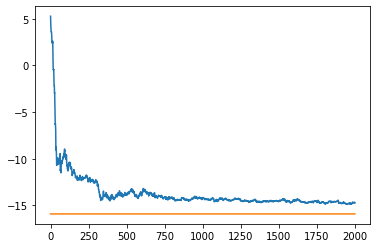

In [200]:
import matplotlib.pyplot as plt

E0 = [np.sort(e)[0] for i in range(len(result))]

El = [result[i]['E'] for i in range(len(result))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)
plt.plot(tl,E0)

### On Chip

In [18]:
def interim_result_callback(job_id, interim_result):
    print(f"interim result: {interim_result}")

In [19]:
backend = provider.get_backend('ibmq_bogota')
options = {'backend_name': backend.name()}
inputs = {"k_max": 3, "phi": phi, "alpha": alpha, "blocks":blocks}
job = provider.runtime.run(program_id, options=options, inputs=inputs, callback=interim_result_callback)

In [ ]:
print(f"job id: {job.job_id()}")
result = job.result()

job id: c5skrdbrrcfjv06gq9p0


In [ ]:
result[2]['E']